# Advanced Content Based Recommendation Net - Optimizations IV



We continue to rework the network architecture to incorporate more of the options below. 

<div style="padding: 10px; border-left: 4px solid #F44336; background-color: #FFEBEE;">
<strong>❗ Important:</strong> This notebook was executed on a Google Colab Environment with a A100 GPU setup. It provides lots of RAM and GPU memory to incorporate the user history sequence into our training. 
</div>

<div style="padding: 10px; border-left: 4px solid #FF9800; background-color: #FFF3E0;">
<strong>⚠️ Warning:</strong> I decided to use the full movielens dataset, so the RecommendationNet has enough data (signals) to learn from. But for this you need an appropriate environment such as Google Colab Pro with a A100 GPU setup.

The step to switch to the full dataset was motivated by two reasons:

- to have enough signals for the model to learn from
- in real live (in companies or for customers) the handling of large datasets is important, so why not use and train it in our Recommendation?Scenario
</div>



# Optimizing Transformer Usage for a Recommendation System

## Overview

The current architecture uses a Transformer to model interactions between `user_profile` and `movie_profile` as a sequence of length 2. While this works, the Transformer can be better utilized by providing it with richer inputs or restructured data. Below are several options to optimize Transformer usage.

---

## Option 2: Include Historical Interactions as a Sequence

### Idea
If historical interactions (e.g., movies watched, ratings) are available, treat them as a temporal sequence.

### Example
- **Historical interaction features** for a user:
  - Movie embeddings → Sequence of embeddings.
  - Interaction metadata (e.g., timestamp, rating) → Additional feature vectors.

**Input to Transformer:**
Combine the current user and movie profiles with historical interaction embeddings:
```
Sequence: [user_embedding, movie_embedding, interaction_1, interaction_2, ..., interaction_n]
Shape: (B, seq_len, transformer_d_model)
```

### Benefits
- Models temporal dependencies in user behavior.
- Captures how historical preferences evolve over time.

This is **the main focus** of this notebook 16.

---

## Option 4: Use Hierarchical Transformers (this is for a later notebook)

### Idea
Use separate Transformers for `user_profile` and `movie_profile`, followed by a global Transformer.

### Steps
1. **Local Transformer:** Process `user_profile` and `movie_profile` separately.
   - User features → Sequence of embeddings → Local Transformer.
   - Movie features → Sequence of embeddings → Local Transformer.

2. **Global Transformer:** Combine outputs of local Transformers into a single sequence and process.

**Example:**
```
Step 1: Local Transformers
- User features: [user_emb_1, user_emb_2, ..., user_emb_n] → (B, seq_len_user, transformer_d_model)
- Movie features: [movie_emb_1, movie_emb_2, ..., movie_emb_m] → (B, seq_len_movie, transformer_d_model)

Step 2: Global Transformer
- Sequence: [user_output, movie_output] → (B, 2, transformer_d_model)
```

### Benefits
- Reduces complexity by processing profiles separately.
- Leverages self-attention within and across profiles.

---

These optimizations ensure better utilization of the Transformer's strengths and provide richer inputs for our recommendation system.


In [2]:
# Uninstall existing TensorFlow framework (if needed)
%pip uninstall -y tensorflow
%pip uninstall -y tensorflow-gpu

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1


In [3]:
%pip install sentence_transformers transformers

In [ ]:
%pip install optuna

In [4]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

# Set new working directory to a specific folder in Google Drive
google_drive_folder = "/content/drive/My Drive/Colab Notebooks/recommendation-net"  # Replace with your folder name
os.chdir(google_drive_folder)

# Verify current working directory
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/My Drive/Colab Notebooks/recommendation-net


In [ ]:
import time
from IPython.display import HTML

# Display a message indicating the keep-alive script is running
print("Running keep-alive script to prevent Colab timeout...")

# JavaScript to simulate activity by clicking on the cell or scrolling
keep_alive_script = """
    <script>
        function preventTimeout() {
            console.log('Preventing timeout...');
            document.body.dispatchEvent(new MouseEvent('mousemove', {bubbles: true}));
        }
        setInterval(preventTimeout, 60000);  // Call every 60 seconds
    </script>
"""
display(HTML(keep_alive_script))

Running keep-alive script to prevent Colab timeout...


# Building the data pipeline
The following code builds the data pipeline so that we have usable data loaders.

In [6]:
# Watch for changes
%load_ext autoreload
%autoreload 2

import pandas as pd
import torch
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer
import numpy as np
from codebase.v16.data import UserProfileCreator, MovieProfileCreator
from codebase.v16.dataset import CustomMovieLensDataset
import os
import torch.multiprocessing
from codebase.v16.utils import collate_fn

# Ensures proper multiprocessing behavior (problematic on google colab env)
#torch.multiprocessing.set_start_method("spawn", force=True)

# for google colab use fork
torch.multiprocessing.set_start_method("fork", force=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_name = "ml-32m"

class Config:
    RATINGS_PATH = 'data/' + dataset_name + '/ratings.csv'
    MOVIES_ENRICHED_PATH = 'data/' + dataset_name + '/movies_enriched_tags.csv'
    USER_ENRICHED_PATH = 'data/' + dataset_name + '/users_enriched_tags.csv'
    USER_EMBEDDINGS_PATH = 'data/' + dataset_name + '/user_profiles.npy'
    MOVIE_EMBEDDINGS_PATH = 'data/' + dataset_name + '/movie_profiles.npy'
    BATCH_SIZE = 1024 * 8
    NUM_WORKERS = 4
    PERSISTENT_WORKERS = True
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    os.environ["TOKENIZERS_PARALLELISM"] = "false"

def load_csv(path):
    """Load a CSV file and return a DataFrame."""
    return pd.read_csv(path)

def validate_ids(ratings, users_enriched, movies_enriched):
    """Filter and validate user and movie IDs."""
    valid_user_ids = set(ratings['userId']).intersection(set(users_enriched['userId']))
    valid_movie_ids = set(ratings['movieId']).intersection(set(movies_enriched['movieId']))
    print(f"Number of valid users: {len(valid_user_ids)}")
    print(f"Number of valid movies: {len(valid_movie_ids)}")
    return valid_user_ids, valid_movie_ids

def map_indices(ratings, valid_user_ids, valid_movie_ids):
    """Map userId and movieId to indices."""
    user_id_to_index = {user_id: idx for idx, user_id in enumerate(valid_user_ids)}
    movie_id_to_index = {movie_id: idx for idx, movie_id in enumerate(valid_movie_ids)}
    ratings = ratings[
        (ratings['userId'].isin(valid_user_ids)) & (ratings['movieId'].isin(valid_movie_ids))
    ]
    ratings['userIndex'] = ratings['userId'].map(user_id_to_index)
    ratings['movieIndex'] = ratings['movieId'].map(movie_id_to_index)
    return ratings

def temporal_split(ratings):
    """Split ratings data into train, validation, and test sets temporally."""
    ratings = ratings.sort_values('timestamp')
    train_end = int(0.7 * len(ratings))
    val_end = int(0.85 * len(ratings))
    return ratings.iloc[:train_end], ratings.iloc[train_end:val_end], ratings.iloc[val_end:]

class ProfileLoader:
    @staticmethod
    def load_or_create_profiles(creator, df, path, message):
        """Load profiles from disk or create and save them."""
        if os.path.exists(path):
            print(f"Loading {message} from disk...")
            profiles = np.load(path)
            id_mappings = np.load(path.replace(".npy", "_id_mappings.npy"), allow_pickle=True).item()
            print(f"{message} loaded.")
        else:
            print(f"Creating {message}...")
            profiles, id_mappings = creator.create_profiles(df)
            np.save(path, profiles)
            np.save(path.replace(".npy", "_id_mappings.npy"), id_mappings)
            print(f"{message} saved to disk.")
        return profiles, id_mappings

def prepare_data(config):
    # Load data
    ratings = load_csv(config.RATINGS_PATH)
    movies_enriched = load_csv(config.MOVIES_ENRICHED_PATH)
    users_enriched = load_csv(config.USER_ENRICHED_PATH)

    # Validate IDs
    valid_user_ids, valid_movie_ids = validate_ids(ratings, users_enriched, movies_enriched)

    # Map indices
    ratings = map_indices(ratings, valid_user_ids, valid_movie_ids)

    # Create genre vocab
    genre_vocab = sorted(
        set(
            [
                genre.strip()
                for genre in ','.join(users_enriched['favorite_genres'].dropna()).split(',')
            ]
            + [
                genre.strip()
                for genre in '|'.join(movies_enriched['genres'].dropna()).split('|')
            ]
        )
    )

    # Temporal split
    train_data, val_data, test_data = temporal_split(ratings)

    return ratings, train_data, val_data, test_data, genre_vocab, valid_user_ids, valid_movie_ids


def prepare_profiles(config, genre_vocab, users_enriched, movies_enriched, valid_user_ids, valid_movie_ids):
    text_model_tags = SentenceTransformer("all-MiniLM-L6-v2").to(config.DEVICE)  # 384
    text_model_plots = SentenceTransformer("all-MiniLM-L12-v2").to(config.DEVICE)  # 384

    user_creator = UserProfileCreator(text_model=text_model_tags, genre_vocab=genre_vocab)
    movie_creator = MovieProfileCreator(
        text_model_tags=text_model_tags, text_model_plots=text_model_plots, genre_vocab=genre_vocab
    )

    filtered_users_df = users_enriched[users_enriched['userId'].isin(valid_user_ids)].reset_index(drop=True)
    user_profiles, id_mappings_user = ProfileLoader.load_or_create_profiles(
        user_creator, filtered_users_df, config.USER_EMBEDDINGS_PATH, "user profiles"
    )

    filtered_movies_df = movies_enriched[movies_enriched['movieId'].isin(valid_movie_ids)].reset_index(drop=True)
    movie_profiles, id_mappings_movies = ProfileLoader.load_or_create_profiles(
        movie_creator, filtered_movies_df, config.MOVIE_EMBEDDINGS_PATH, "movie profiles"
    )

    return user_profiles, movie_profiles, id_mappings_user, id_mappings_movies

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
config = Config()

# Prepare data
ratings, train_data, val_data, test_data, genre_vocab, valid_user_ids, valid_movie_ids = prepare_data(config)

def build_user_histories(ratings, movie_profiles, movie_token_dims, max_history_items=25):
    """
    Build user histories as tokenized sequences for each user, padded to max_history_items.
    Creates:
        - self.user_history_tensors: A dictionary mapping userIndex to tokenized histories.
        - self.user_history_masks: A dictionary mapping userIndex to masks for valid history entries.
    """
    # Check that required columns exist in the ratings DataFrame
    required_cols = {'userIndex', 'movieIndex', 'rating', 'timestamp'}
    if not required_cols.issubset(ratings.columns):
        raise ValueError(f"ratings DataFrame must have columns {required_cols}")

    # Sort ratings by userIndex and timestamp
    ratings = ratings.sort_values(['userIndex', 'timestamp'])

    # Group ratings by userIndex
    grouped = ratings.groupby('userIndex', sort=False)

    # Initialize user history storage
    user_history_tensors = {}
    user_history_masks = {}

    for user_idx, group in grouped:
        # Tail to keep the most recent interactions up to max_history_items
        recent_interactions = group.tail(max_history_items)

        # Prepare history tokens and mask
        history_tokens_list = []

        for _, row in recent_interactions.iterrows():
            movie_idx = int(row['movieIndex'])
            rating_val = float(row['rating'])
            ts_val = float(row['timestamp'])

            # Tokenize the movie profile for this interaction
            movie_profile_tensor = torch.tensor(movie_profiles[movie_idx], dtype=torch.float32)
            movie_tokens = slice_tokens(movie_profile_tensor, movie_token_dims)

            # Add normalized rating and timestamp as separate fields
            movie_tokens['rating'] = torch.tensor([rating_val], dtype=torch.float32)  # [1]
            movie_tokens['timestamp'] = torch.tensor([ts_val], dtype=torch.float32)  # [1]

            history_tokens_list.append(movie_tokens)

        # Pad history to max_history_items
        padded_history_tokens, history_mask = pad_and_mask(history_tokens_list, max_history_items)

        # Store in dictionaries
        user_history_tensors[user_idx] = padded_history_tokens
        user_history_masks[user_idx] = history_mask

    return user_history_tensors, user_history_masks

def slice_tokens(full_profile, token_dims):
        profile_dict = {}
        start_idx = 0
        for token_name, dim in token_dims.items():
            end_idx = start_idx + dim
            profile_dict[token_name] = full_profile[start_idx:end_idx]
            start_idx = end_idx
        return profile_dict

def pad_and_mask(tokens_list, max_length):
    """
    Pad the tokenized history to max_length and create a mask.

    Args:
        tokens_list (list of dict): List of token dictionaries for the history.
        max_length (int): Maximum length of the history sequence.

    Returns:
        padded_tokens (dict): Padded token sequences for the history.
        mask (torch.Tensor): Mask indicating valid entries (1 for valid, 0 for padding).
    """
    # Initialize storage for padded tokens
    padded_tokens = {
        key: torch.zeros(max_length, *value.shape, dtype=torch.float32)
        for key, value in tokens_list[0].items()
    }

    mask = torch.zeros(max_length, dtype=torch.float32)

    # Fill in valid tokens
    for i, tokens in enumerate(tokens_list):
        if i >= max_length:
            break
        for key, value in tokens.items():
            padded_tokens[key][i] = value
        mask[i] = 1.0  # Mark as valid

    return padded_tokens, mask

def prepare_data_pipleline():
    # Dataset preparation
    user_token_dims = {
        "userId": 1, "age": 1, "num_reviews": 1, "avg_rating": 1,
        "genres": len(genre_vocab), "spending_category": 3, "gender": 2, "tags": 384
    }
    movie_token_dims = {
        "movieId": 1, "budget": 1, "popularity": 1, "runtime": 1, "vote_average": 1, "vote_count": 1,
        "overview": 384, "genres": len(genre_vocab), "tags": 384
    }

    train_dataset = CustomMovieLensDataset(
        train_data, genre_vocab, user_token_dims, movie_token_dims,
        100)

    val_dataset = CustomMovieLensDataset(
        val_data, genre_vocab, user_token_dims, movie_token_dims,
        100)

    test_dataset = CustomMovieLensDataset(
        test_data, genre_vocab, user_token_dims, movie_token_dims,
        100)

    train_loader = DataLoader(
        train_dataset, batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        collate_fn=collate_fn,
        persistent_workers=config.PERSISTENT_WORKERS
    )

    val_loader = DataLoader(
        val_dataset, batch_size=config.BATCH_SIZE, num_workers=config.NUM_WORKERS, collate_fn=collate_fn, pin_memory=False,
        persistent_workers=config.PERSISTENT_WORKERS)

    test_loader = DataLoader(
        test_dataset, batch_size=config.BATCH_SIZE, num_workers=config.NUM_WORKERS, collate_fn=collate_fn, pin_memory=False,
        persistent_workers=config.PERSISTENT_WORKERS)

    print("Data preparation complete!")
    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    return (
            train_loader, val_loader, test_loader,
            ratings, train_data, val_data, test_data,
            genre_vocab,
            valid_movie_ids, valid_user_ids
        )

<ipython-input-6-82b200f37059>:40: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path)


Number of valid users: 200948
Number of valid movies: 84432


Valid user and movie IDs:
200948
84432

Rated Movies: 84432 out of 84432 total movies (100.00%)
Active Users: 200948 (Users who have rated at least one movie)

Summary of Number of Movies Rated by Users:
count    200948.000000
mean        159.246193
std         282.025462
min          20.000000
25%          36.000000
50%          73.000000
75%         167.000000
max       33332.000000
Name: movieId, dtype: float64


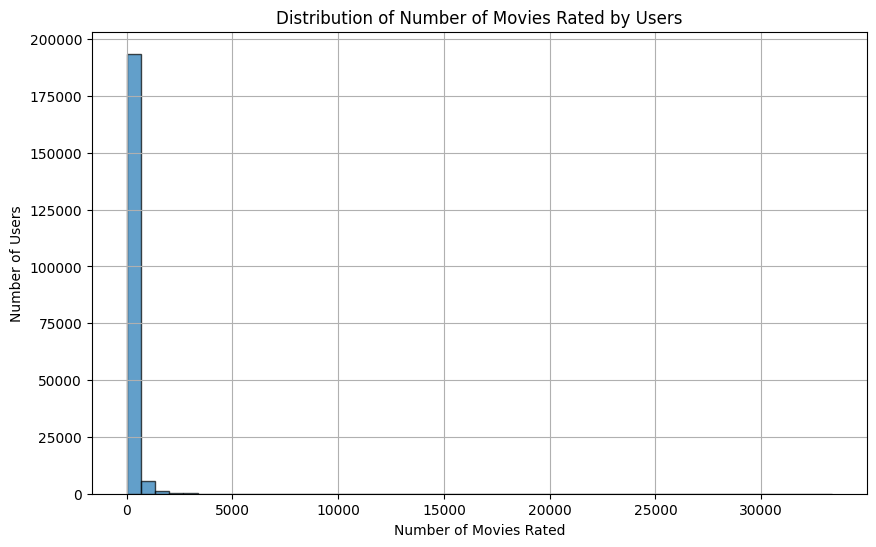


Number of Unique Users: 200948
Number of Unique Movies: 84432
Users in Train: 154612
Users in Val: 31058
Users in Test: 30155
Movies in Train: 36529
Movies in Val: 54692
Movies in Test: 70541

User Overlaps:
Train-Val Overlap: 7051 users
Train-Test Overlap: 4038 users
Val-Test Overlap: 6951 users

Movie Overlaps:
Train-Val Overlap: 31982 movies
Train-Test Overlap: 30120 movies
Val-Test Overlap: 43544 movies

Temporal Splitting Validation:
Train Max Timestamp: 1476365246
Val Min Timestamp: 1476365256
Val Max Timestamp: 1573330503
Test Min Timestamp: 1573330512
Temporal splitting is valid.


In [ ]:
import matplotlib.pyplot as plt

def analyze_and_validate_splits(train_data, val_data, test_data):
    """
    Analyze overlaps and validate temporal splitting of train, val, and test datasets.

    Args:
        train_data (pd.DataFrame): Training data with columns ['userId', 'movieId', 'rating', 'timestamp', 'userIndex', 'movieIndex'].
        val_data (pd.DataFrame): Validation data with the same structure as train_data.
        test_data (pd.DataFrame): Test data with the same structure as train_data.
    """
    # Extract unique users and movies from each split
    train_users = set(train_data['userIndex'])
    val_users = set(val_data['userIndex'])
    test_users = set(test_data['userIndex'])

    train_movies = set(train_data['movieIndex'])
    val_movies = set(val_data['movieIndex'])
    test_movies = set(test_data['movieIndex'])

    # Compute overlaps
    user_overlap_train_val = train_users & val_users
    user_overlap_train_test = train_users & test_users
    user_overlap_val_test = val_users & test_users

    movie_overlap_train_val = train_movies & val_movies
    movie_overlap_train_test = train_movies & test_movies
    movie_overlap_val_test = val_movies & test_movies

    # Print number of users and movies in each set
    print("\nNumber of Unique Users:", len(train_users | val_users | test_users))
    print("Number of Unique Movies:", len(train_movies | val_movies | test_movies))
    print("Users in Train:", len(train_users))
    print("Users in Val:", len(val_users))
    print("Users in Test:", len(test_users))
    print("Movies in Train:", len(train_movies))
    print("Movies in Val:", len(val_movies))
    print("Movies in Test:", len(test_movies))
    print()

    # Print user and movie overlaps
    print("User Overlaps:")
    print(f"Train-Val Overlap: {len(user_overlap_train_val)} users")
    print(f"Train-Test Overlap: {len(user_overlap_train_test)} users")
    print(f"Val-Test Overlap: {len(user_overlap_val_test)} users")
    print("\nMovie Overlaps:")
    print(f"Train-Val Overlap: {len(movie_overlap_train_val)} movies")
    print(f"Train-Test Overlap: {len(movie_overlap_train_test)} movies")
    print(f"Val-Test Overlap: {len(movie_overlap_val_test)} movies")

    # Validate temporal splitting
    def validate_temporal_order(train, val, test):
        train_max_time = train['timestamp'].max()
        val_min_time = val['timestamp'].min()
        val_max_time = val['timestamp'].max()
        test_min_time = test['timestamp'].min()

        print("\nTemporal Splitting Validation:")
        print(f"Train Max Timestamp: {train_max_time}")
        print(f"Val Min Timestamp: {val_min_time}")
        print(f"Val Max Timestamp: {val_max_time}")
        print(f"Test Min Timestamp: {test_min_time}")

        if train_max_time <= val_min_time and val_max_time <= test_min_time:
            print("Temporal splitting is valid.")
        else:
            print("Temporal splitting is invalid. Check timestamp ranges.")

    # Call temporal validation
    validate_temporal_order(train_data, val_data, test_data)

print("Valid user and movie IDs:")
print(len(valid_user_ids))
print(len(valid_movie_ids))

def analyze_user_movie_counts(ratings, total_movies=None):
    """
    Analyze how many movies each user has rated in the given ratings DataFrame,
    and provide additional insights about rated movies and active users.

    Args:
        ratings (pd.DataFrame): Ratings DataFrame with at least ['userId', 'movieId'] columns.
        total_movies (int, optional): Total number of movies in the dataset.

    Returns:
        pd.Series: A summary of the number of movies rated by each user.
    """
    # Count the number of movies rated by each user
    user_movie_counts = ratings.groupby('userId')['movieId'].count()

    # Count unique movies rated
    rated_movies = ratings['movieId'].nunique()

    # Count unique users who have rated at least one movie
    active_users = ratings['userId'].nunique()

    # Relation between rated movies and total movies
    if total_movies is not None:
        rated_movies_percentage = (rated_movies / total_movies) * 100
        print(f"\nRated Movies: {rated_movies} out of {total_movies} total movies ({rated_movies_percentage:.2f}%)")
    else:
        print(f"\nRated Movies: {rated_movies} (Total movies not provided)")

    # Print the number of active users
    print(f"Active Users: {active_users} (Users who have rated at least one movie)")

    # Summarize the distribution of user ratings
    print("\nSummary of Number of Movies Rated by Users:")
    print(user_movie_counts.describe())

    # Plot the distribution of movies rated by users
    plt.figure(figsize=(10, 6))
    plt.hist(user_movie_counts, bins=50, alpha=0.7, edgecolor='black')
    plt.title("Distribution of Number of Movies Rated by Users")
    plt.xlabel("Number of Movies Rated")
    plt.ylabel("Number of Users")
    plt.grid(True)
    plt.show()

    return user_movie_counts

user_movie_counts = analyze_user_movie_counts(ratings, total_movies=len(valid_movie_ids))
analyze_and_validate_splits(train_data, val_data, test_data)

In [10]:
import pickle
import os
import gzip

def save_user_histories_and_masks(user_histories, user_masks, filepath="user_histories_and_masks.pkl"):
    """
    Save user_histories and user_masks to a file using pickle.

    Args:
        user_histories (dict): The user histories to save.
        user_masks (dict): The user masks to save.
        filepath (str): Path to save the file.
    """
    with open(filepath, "wb") as f:
        pickle.dump({"user_histories": user_histories, "user_masks": user_masks}, f)
    print(f"Saved user_histories and user_masks to {filepath}")

def load_user_histories_and_masks(filepath="user_histories_and_masks.pkl"):
    """
    Load user_histories and user_masks from a file using pickle.

    Args:
        filepath (str): Path to the file to load.

    Returns:
        tuple: (user_histories, user_masks)
    """
    with open(filepath, "rb") as f:
        data = pickle.load(f)
    print(f"Loaded user_histories and user_masks from {filepath}")
    return data["user_histories"], data["user_masks"]

import gzip

def save_compressed(filepath, obj):
    with gzip.open(filepath, "wb") as f:
        pickle.dump(obj, f)

def load_compressed(filepath):
    with gzip.open(filepath, "rb") as f:
        return pickle.load(f)

def get_or_create_user_histories_and_masks(
    ratings,
    movie_profiles,
    movie_token_dims,
    max_history_items=25,
    archive_path="user_histories_and_masks.pkl.gz"
):
    """
    Detects if a compressed archive of user histories and masks exists.
    If it exists, load it; otherwise, create, save, and compress it.

    Args:
        ratings (DataFrame): The ratings data.
        movie_profiles (ndarray): Precomputed movie profiles.
        movie_token_dims (dict): Token dimensions for movie profiles.
        max_history_items (int): Max number of history items.
        archive_path (str): Path to the compressed archive file.

    Returns:
        tuple: (user_histories, user_masks)
    """
    def save_compressed(filepath, obj):
        with gzip.open(filepath, "wb") as f:
            pickle.dump(obj, f)

    def load_compressed(filepath):
        with gzip.open(filepath, "rb") as f:
            return pickle.load(f)

    # Check if the compressed archive exists
    if os.path.exists(archive_path):
        print(f"Archive found at {archive_path}. Loading user histories and masks...")
        data = load_compressed(archive_path)
        return data["user_histories"], data["user_masks"]

    # If not, create the user histories and masks
    print(f"Archive not found at {archive_path}. Creating user histories and masks...")
    user_histories, user_masks = build_user_histories(ratings, movie_profiles, movie_token_dims, max_history_items)

    # Save and compress the data
    print(f"Saving and compressing user histories and masks to {archive_path}...")
    save_compressed(archive_path, {"user_histories": user_histories, "user_masks": user_masks})
    print(f"User histories and masks saved to {archive_path}.")

    return user_histories, user_masks

In [11]:
# Watch for changes
%load_ext autoreload
%autoreload 2

# Prepare profiles first
user_profiles, movie_profiles, id_mappings_user, id_mappings_movies = prepare_profiles(
    config, genre_vocab, load_csv(config.USER_ENRICHED_PATH), load_csv(config.MOVIES_ENRICHED_PATH),
    valid_user_ids, valid_movie_ids
)

# Token Dim Dictionaries
movie_token_dims = {
    "movieId": 1, "budget": 1, "popularity": 1, "runtime": 1, "vote_average": 1, "vote_count": 1,
    "overview": 384, "genres": len(genre_vocab), "tags": 384
}

# Precompute user histories ratings, movie_profiles, movie_token_dims, max_history_items=100
user_histories, user_masks = get_or_create_user_histories_and_masks(
    ratings,
    movie_profiles,
    movie_token_dims,
    max_history_items=25,
    archive_path=f"data/{dataset_name}/user_histories_and_masks.pkl.gz"
)

print("Shapes of precomputed user_histories, user_masks:")

for key, value in user_histories[0].items():
    print(f"{key}: {value.shape}")

print(f"Mask: {user_masks[0].shape}")

print()
print("Precomputation of user_histories, user_masks complete!")

CustomMovieLensDataset.shared_user_profiles = user_profiles
CustomMovieLensDataset.shared_movie_profiles = movie_profiles
CustomMovieLensDataset.shared_precomputed_user_histories = user_histories
CustomMovieLensDataset.shared_precomputed_user_masks = user_masks

(
    train_loader,
    val_loader,
    test_loader,
    ratings,
    train_data,
    val_data,
    test_data,
    genre_vocab,
    valid_movie_ids,
    valid_user_ids
) = prepare_data_pipleline()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<ipython-input-6-82b200f37059>:40: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loading user profiles from disk...
user profiles loaded.
Loading movie profiles from disk...
movie profiles loaded.
Archive not found at data/ml-32m/user_histories_and_masks.pkl.gz. Creating user histories and masks...
Saving and compressing user histories and masks to data/ml-32m/user_histories_and_masks.pkl.gz...
User histories and masks saved to data/ml-32m/user_histories_and_masks.pkl.gz.
Shapes of precomputed user_histories, user_masks:
movieId: torch.Size([25, 1])
budget: torch.Size([25, 1])
popularity: torch.Size([25, 1])
runtime: torch.Size([25, 1])
vote_average: torch.Size([25, 1])
vote_count: torch.Size([25, 1])
overview: torch.Size([25, 384])
genres: torch.Size([25, 20])
tags: torch.Size([25, 384])
rating: torch.Size([25, 1])
timestamp: torch.Size([25, 1])
Mask: torch.Size([25])

Precomputation of user_histories, user_masks complete!
Data preparation complete!
Train samples: 22400142
Validation samples: 4800031
Test samples: 4800031


## Let's inspect the data and the pipeline we just created:

In [ ]:
def get_sample_batch(loader):
    """Fetch a single batch of data from a DataLoader."""
    for batch in loader:
        return batch  # Return the first batch

# Extract a sample batch from the train loader
sample_batch = get_sample_batch(train_loader)

# Unpack the batch
user_tokens, movie_tokens, ratings, genre_overlap, user_history_tensor, user_history_mask = sample_batch

# print the shapes of the tensors
print("User properties (movie token + rating + timestamp):", len(user_history_tensor))

for key, value in user_history_tensor.items():
    print(f"{key}: {value.shape}")

print("User history mask:", user_history_mask.shape)

User properties (movie token + rating + timestamp): 11
movieId: torch.Size([8192, 25, 1])
budget: torch.Size([8192, 25, 1])
popularity: torch.Size([8192, 25, 1])
runtime: torch.Size([8192, 25, 1])
vote_average: torch.Size([8192, 25, 1])
vote_count: torch.Size([8192, 25, 1])
overview: torch.Size([8192, 25, 384])
genres: torch.Size([8192, 25, 20])
tags: torch.Size([8192, 25, 384])
rating: torch.Size([8192, 25, 1])
timestamp: torch.Size([8192, 25, 1])
User history mask: torch.Size([8192, 25])


### Test the data loader

Let's visualize data from the created loaders.

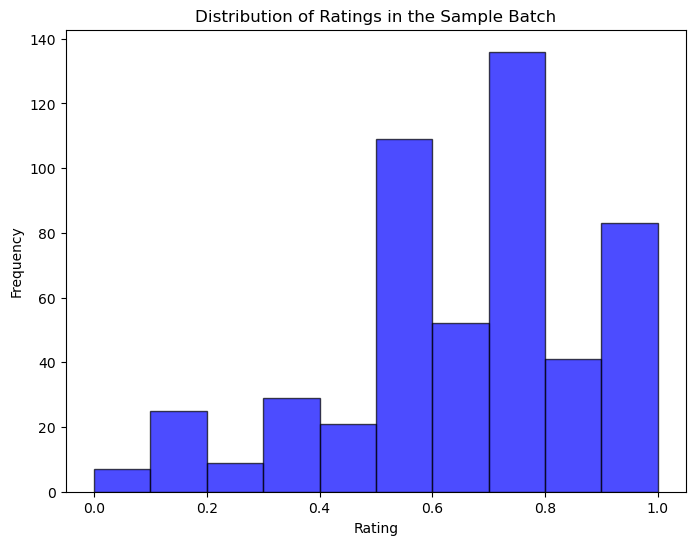

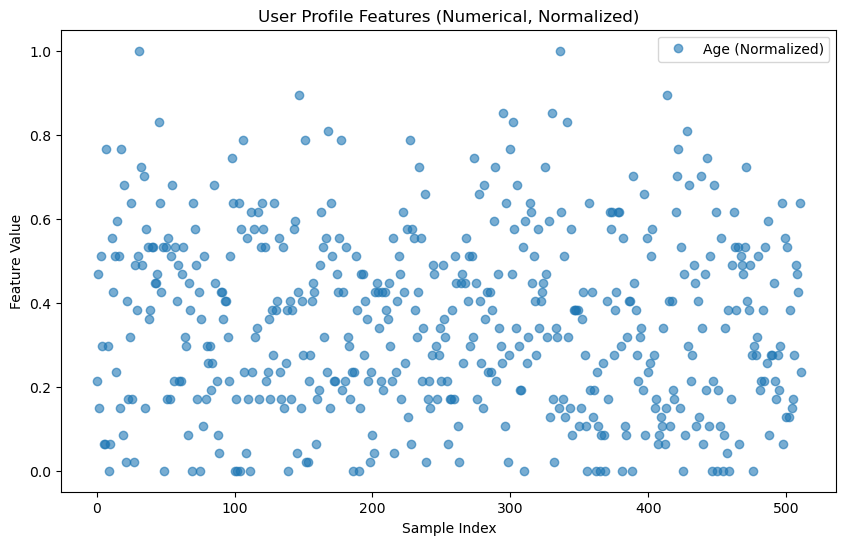

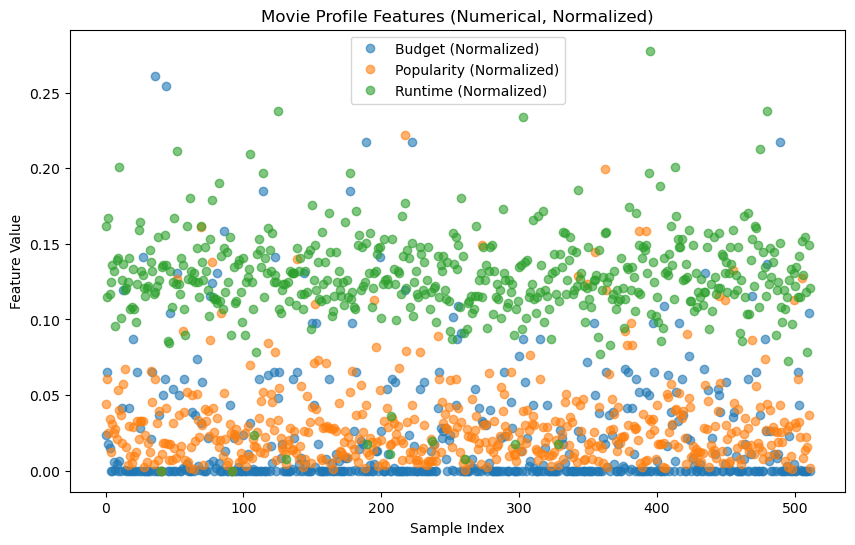

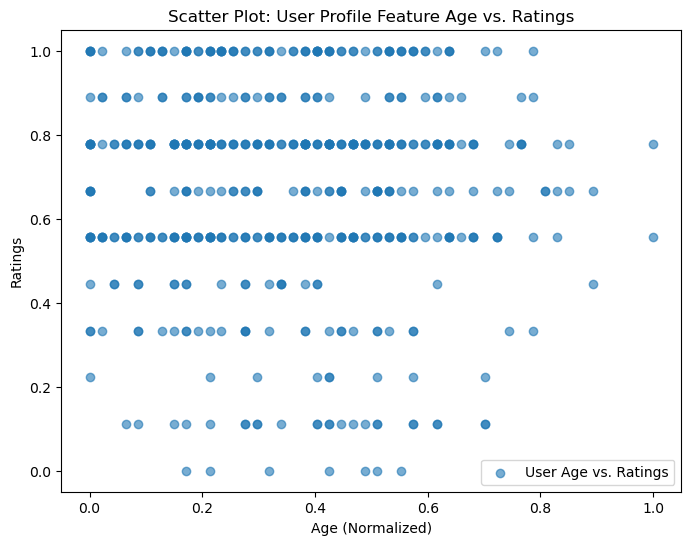

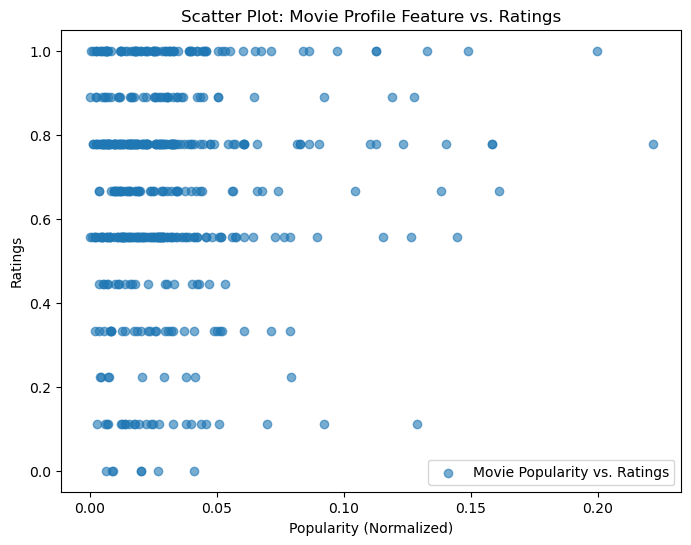

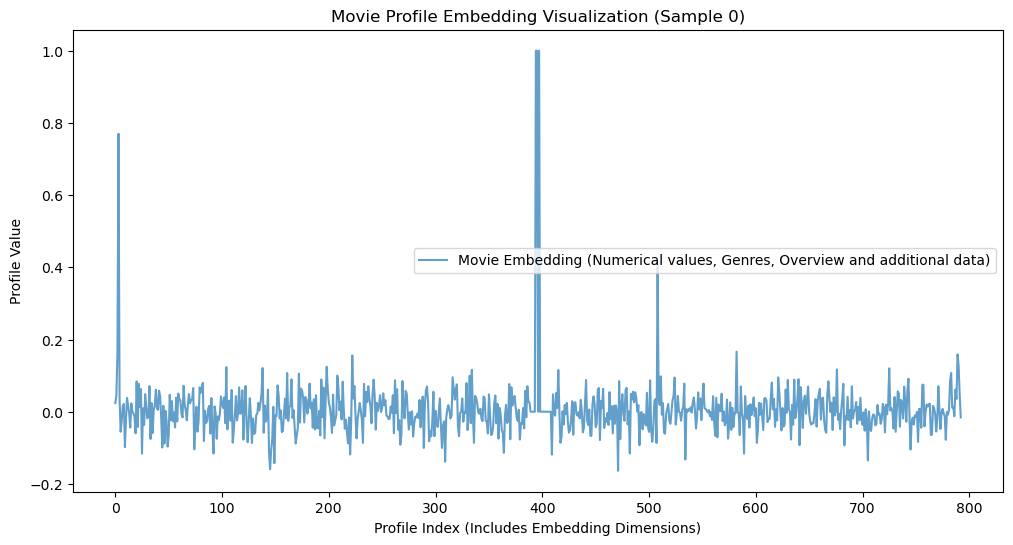

User Profiles data:


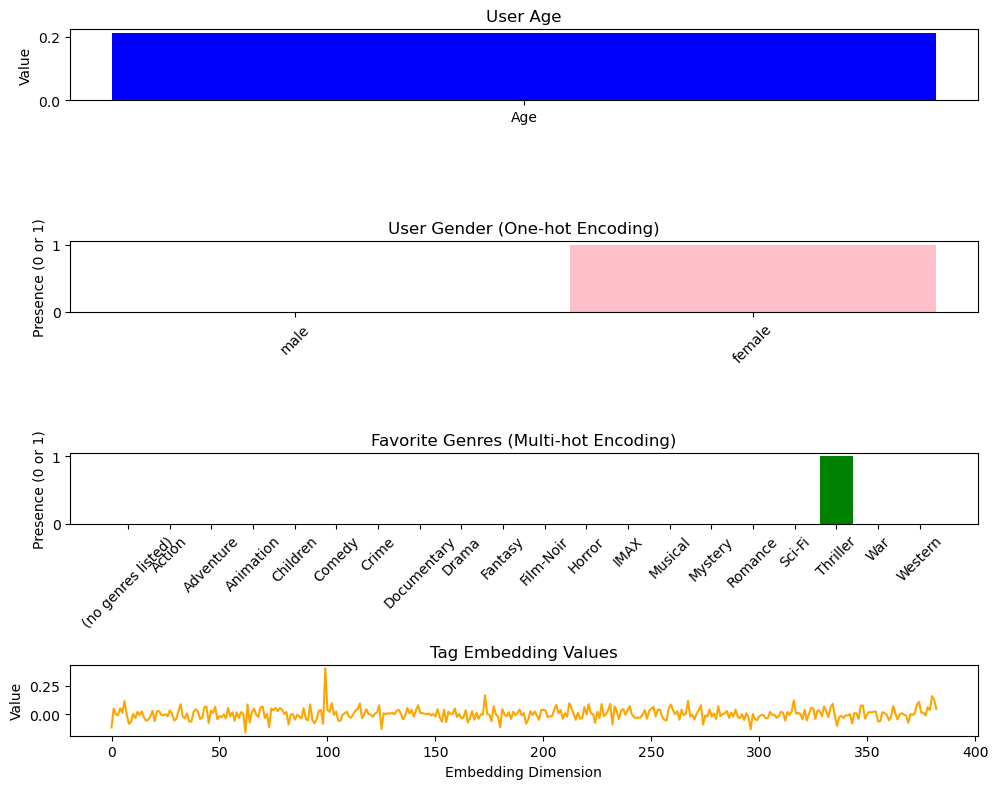

Movie Profiles data:


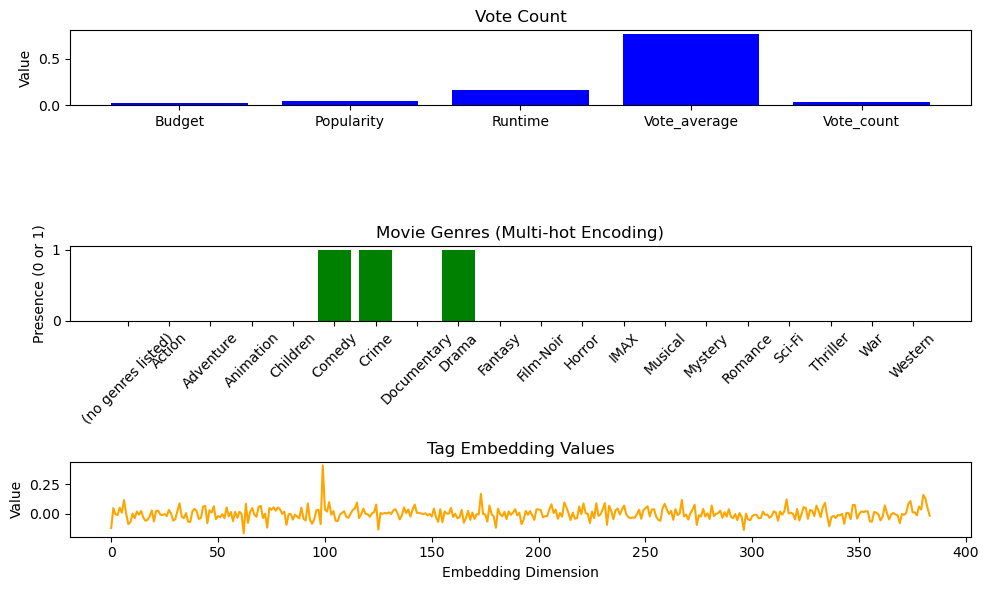

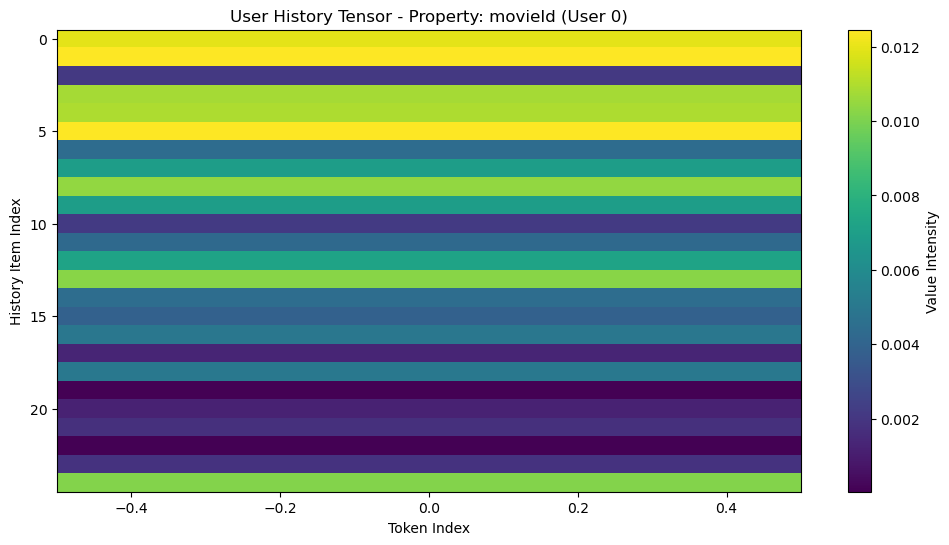


--- Property: movieId ---
Valid History Length: 25
Mean: 0.01, Std: 0.00


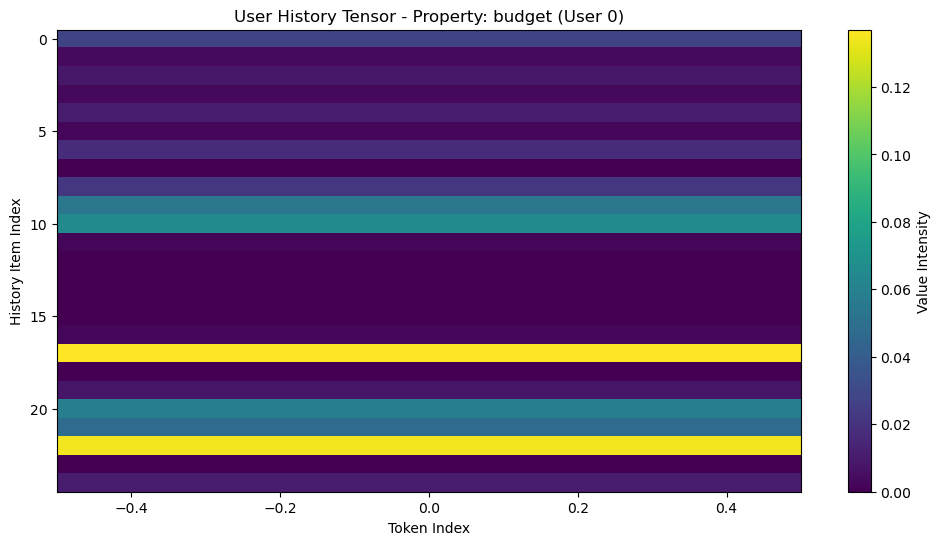


--- Property: budget ---
Valid History Length: 25
Mean: 0.02, Std: 0.04


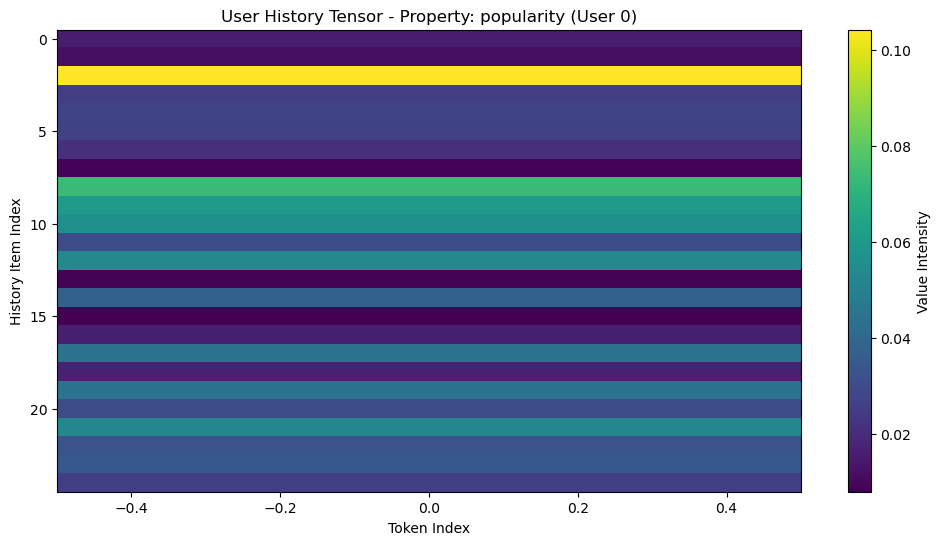


--- Property: popularity ---
Valid History Length: 25
Mean: 0.03, Std: 0.02


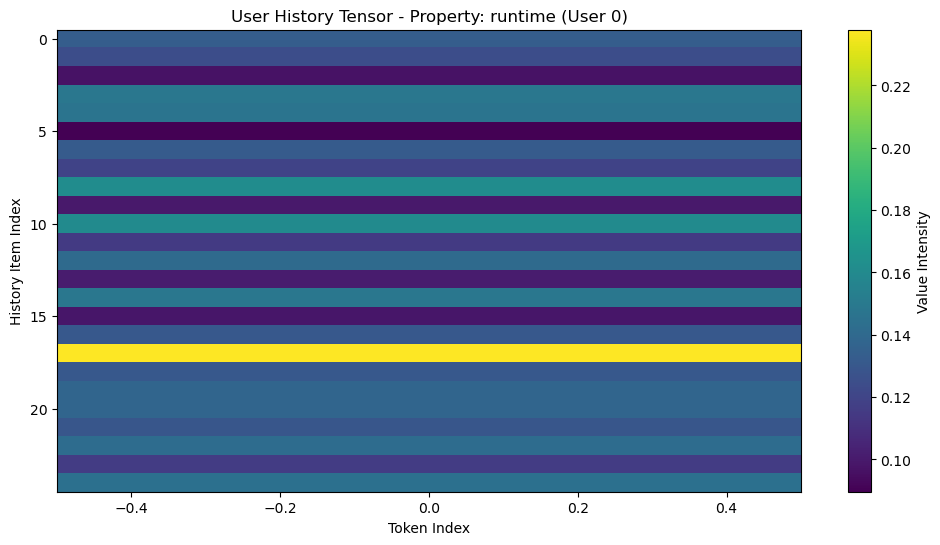


--- Property: runtime ---
Valid History Length: 25
Mean: 0.13, Std: 0.03


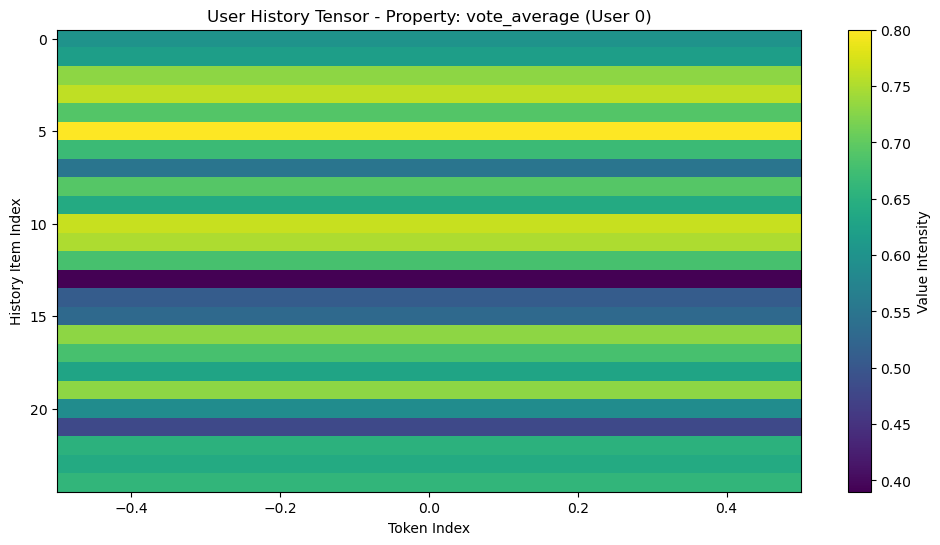


--- Property: vote_average ---
Valid History Length: 25
Mean: 0.65, Std: 0.10


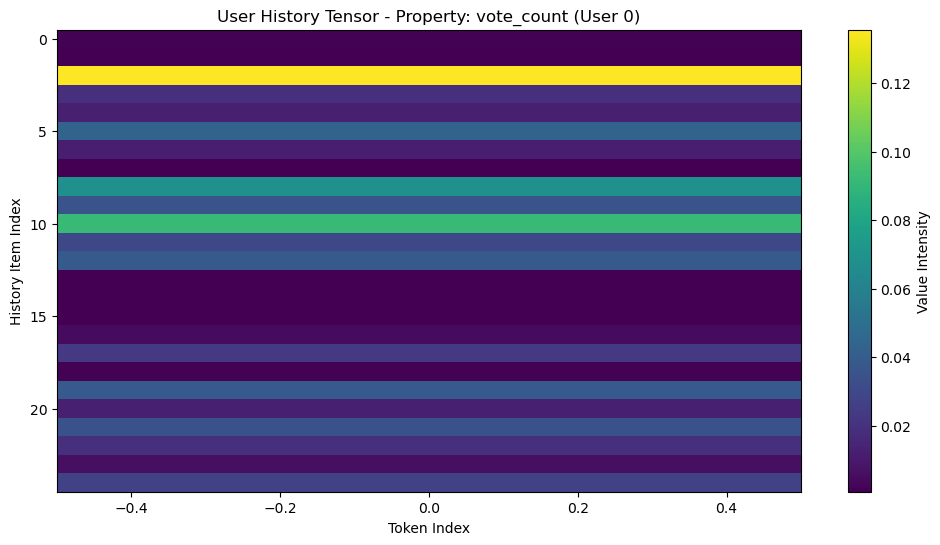


--- Property: vote_count ---
Valid History Length: 25
Mean: 0.03, Std: 0.03


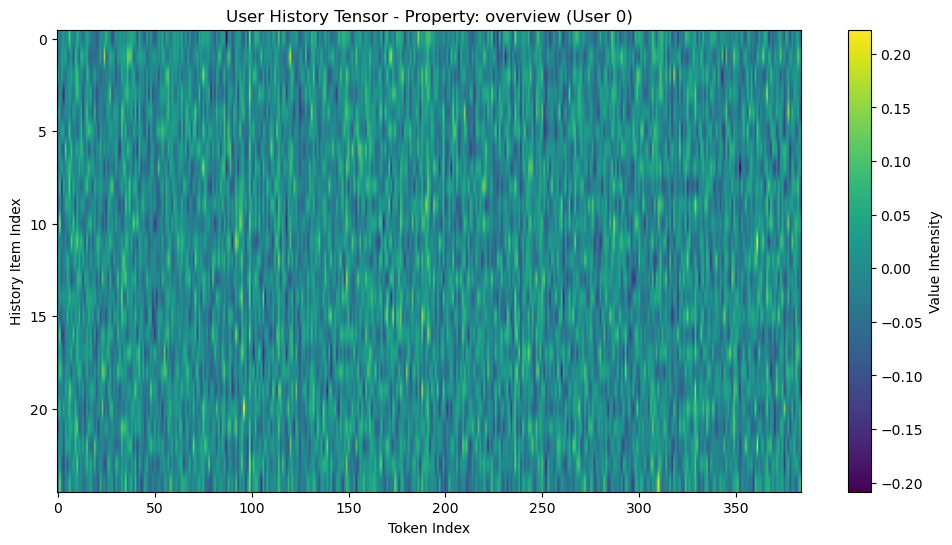


--- Property: overview ---
Valid History Length: 25
Mean: -0.00, Std: 0.05


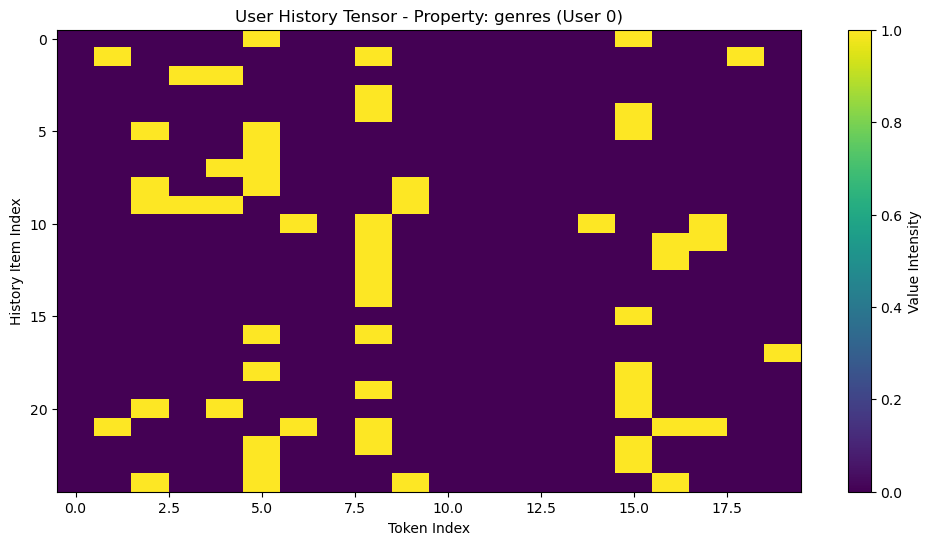


--- Property: genres ---
Valid History Length: 25
Mean: 0.12, Std: 0.32


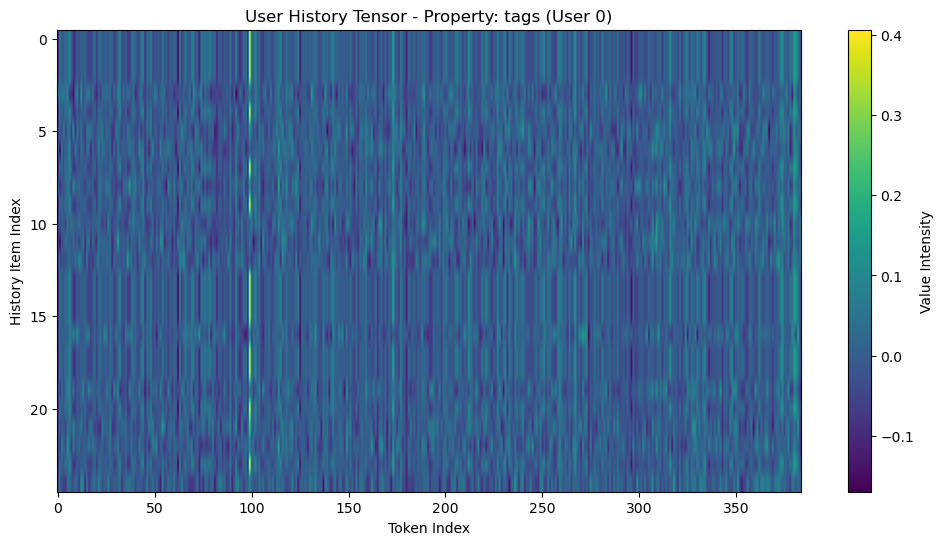


--- Property: tags ---
Valid History Length: 25
Mean: 0.00, Std: 0.05


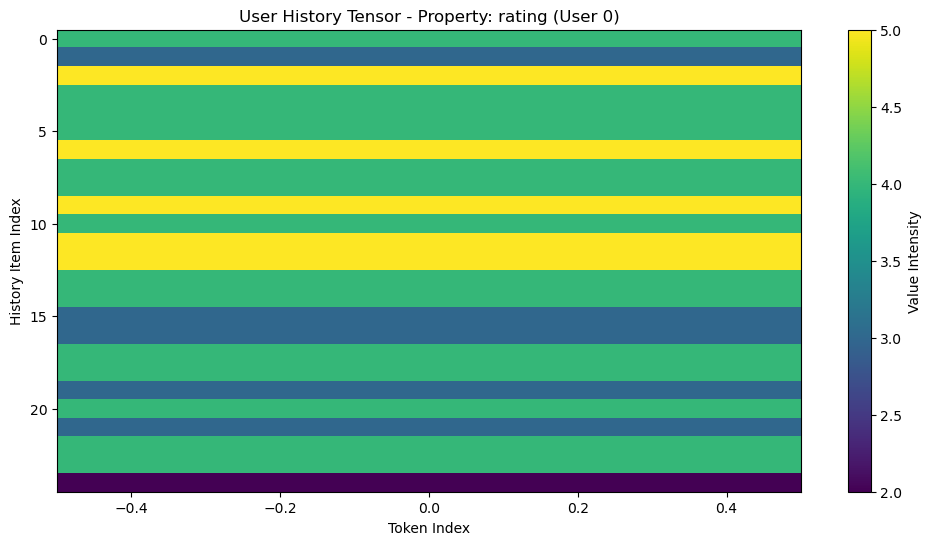


--- Property: rating ---
Valid History Length: 25
Mean: 3.92, Std: 0.74


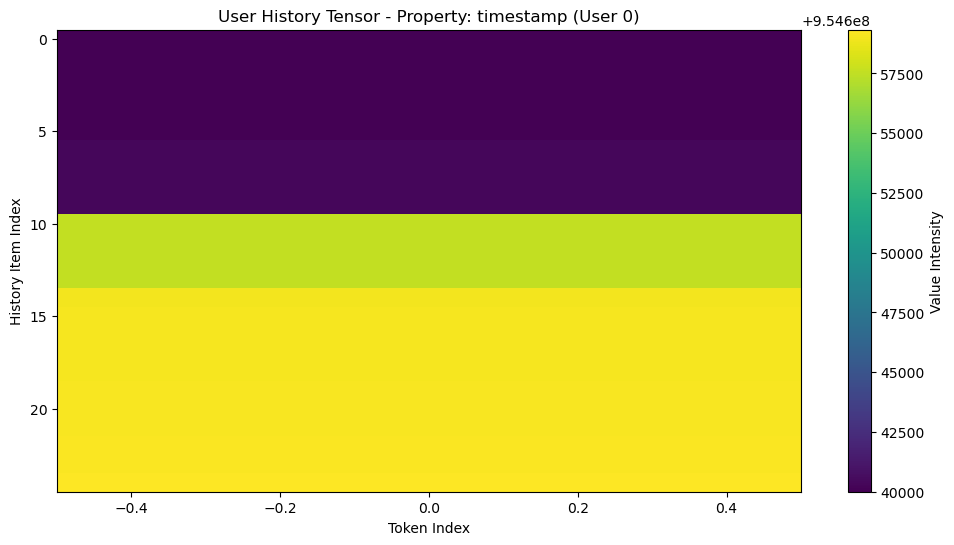


--- Property: timestamp ---
Valid History Length: 25
Mean: 954651264.00, Std: 9105.33


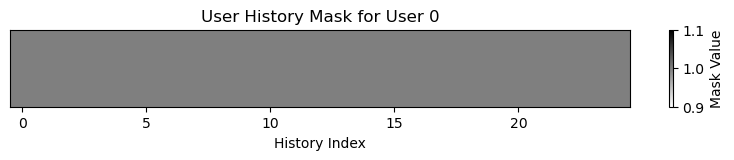

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Helper function to fetch a batch of data from the DataLoader
def get_sample_batch(loader):
    """Fetch a single batch of data from a DataLoader."""
    for batch in loader:
        return batch  # Return the first batch

# Helper function to convert token dictionaries to flat profiles
def flatten_profiles(token_dict):
    """Flatten token dictionaries into a single tensor."""
    return torch.cat([value for value in token_dict.values()], dim=1).numpy()

def plot_user_profile(user_profiles, genre_vocab, tag_embedding_dim, sample_idx):
    """
    Plot a visualization of a user profile.

    Args:
        user_profiles (np.ndarray): Array of user profiles.
        genre_vocab (list): List of all possible genres.
        tag_embedding_dim (int): Dimension of tag embeddings.
    """
    user_profile = user_profiles[sample_idx]  # Select the first user profile for demonstration

    # Profile breakdown
    age = user_profile[1]
    genres = user_profile[4:4 + len(genre_vocab)]
    tags = user_profile[4 + len(genre_vocab) + 3 + 2:4 + len(genre_vocab) + 3 + 2 + tag_embedding_dim]
    gender = user_profile[4 + len(genre_vocab) + 3:4 + len(genre_vocab) + 3 + 2]

    # Plot
    _, axes = plt.subplots(4, 1, figsize=(10, 8))

    axes[0].bar(["Age"], [age], color='blue')
    axes[0].set_title("User Age")
    axes[0].set_ylabel("Value")

    axes[1].bar(['male', 'female'], gender, color='pink')
    axes[1].set_title("User Gender (One-hot Encoding)")
    axes[1].set_ylabel("Presence (0 or 1)")
    axes[1].tick_params(axis='x', rotation=45)

    axes[2].bar(genre_vocab, genres, color='green')
    axes[2].set_title("Favorite Genres (Multi-hot Encoding)")
    axes[2].set_ylabel("Presence (0 or 1)")
    axes[2].tick_params(axis='x', rotation=45)

    axes[3].plot(tags, color='orange')
    axes[3].set_title("Tag Embedding Values")
    axes[3].set_ylabel("Value")
    axes[3].set_xlabel("Embedding Dimension")

    plt.tight_layout()
    plt.show()

def plot_movie_profile(movie_profiles, genre_vocab, tag_embedding_dim, sample_idx=0):
    """
    Plot a visualization of a movie profile.

    Args:
        movie_profiles (np.ndarray): Array of movie profiles.
        genre_vocab (list): List of all possible genres.
        tag_embedding_dim (int): Dimension of tag embeddings.
    """
    movie_profile = movie_profiles[sample_idx]  # Select the first movie profile for demonstration

    # Profile breakdown ('budget', 'popularity', 'runtime', 'vote_average', 'vote_count')
    budget = movie_profile[1]
    popularity = movie_profile[2]
    runtime = movie_profile[3]
    vote_average = movie_profile[4]
    vote_count = movie_profile[5]
    genres = movie_profile[6+tag_embedding_dim:6+tag_embedding_dim + len(genre_vocab)]
    tags = movie_profile[6+tag_embedding_dim + len(genre_vocab):6+tag_embedding_dim + len(genre_vocab) + tag_embedding_dim]

    # Plot
    _, axes = plt.subplots(3, 1, figsize=(10, 6))

    axes[0].bar(["Budget"], [budget], color='blue')
    axes[0].set_title("Movie Budget")
    axes[0].set_ylabel("Value")

    axes[0].bar(["Popularity"], [popularity], color='blue')
    axes[0].set_title("Popularity")
    axes[0].set_ylabel("Value")

    axes[0].bar(["Runtime"], [runtime], color='blue')
    axes[0].set_title("Runtime")
    axes[0].set_ylabel("Value")

    axes[0].bar(["Vote_average"], [vote_average], color='blue')
    axes[0].set_title("Vote Average")
    axes[0].set_ylabel("Value")

    axes[0].bar(["Vote_count"], [vote_count], color='blue')
    axes[0].set_title("Vote Count")
    axes[0].set_ylabel("Value")

    axes[1].bar(genre_vocab, genres, color='green')
    axes[1].set_title("Movie Genres (Multi-hot Encoding)")
    axes[1].set_ylabel("Presence (0 or 1)")
    axes[1].tick_params(axis='x', rotation=45)

    axes[2].plot(tags, color='orange')
    axes[2].set_title("Tag Embedding Values")
    axes[2].set_ylabel("Value")
    axes[2].set_xlabel("Embedding Dimension")

    plt.tight_layout()
    plt.show()

def visualize_single_user_history_tokenized(user_history_tensor, user_history_mask, sample_idx=0):
    """
    Visualize the user history tensor and mask for a single user when tokenized by properties.

    Args:
        user_history_tensor (dict): Dictionary of tokenized properties with shape:
            {property_name: torch.Tensor of shape [batch_size, max_history_items, token_dim]}.
        user_history_mask (torch.Tensor): Mask of shape [batch_size, max_history_items].
        sample_idx (int): Index of the user in the batch to visualize.
    """
    # Extract mask and apply it
    single_mask = user_history_mask[sample_idx].cpu().numpy()  # Shape: [max_history_items]

    # Iterate over tokenized properties
    for property_name, tensor in user_history_tensor.items():
        # Extract the specific property tensor for the user
        property_tensor = tensor[sample_idx].cpu().numpy()  # Shape: [max_history_items, token_dim]

        # Apply mask to filter valid entries
        masked_property_tensor = property_tensor * single_mask[:, None]

        # Visualize the property tensor as a heatmap
        plt.figure(figsize=(12, 6))
        plt.title(f"User History Tensor - Property: {property_name} (User {sample_idx})")
        plt.imshow(masked_property_tensor, aspect="auto", cmap="viridis")
        plt.colorbar(label="Value Intensity")
        plt.xlabel("Token Index")
        plt.ylabel("History Item Index")
        plt.show()

        # Print summary statistics for this property
        print(f"\n--- Property: {property_name} ---")
        valid_values = masked_property_tensor[single_mask == 1]
        print(f"Valid History Length: {int(single_mask.sum())}")
        print(f"Mean: {np.mean(valid_values):.2f}, Std: {np.std(valid_values):.2f}")

    # Visualize the mask itself
    plt.figure(figsize=(10, 1))
    plt.title(f"User History Mask for User {sample_idx}")
    plt.imshow(single_mask[None, :], aspect="auto", cmap="binary", interpolation="nearest")
    plt.colorbar(label="Mask Value")
    plt.xlabel("History Index")
    plt.yticks([])
    plt.show()


# Extract a sample batch from the train loader
sample_batch = get_sample_batch(train_loader)

# Unpack the batch
user_tokens, movie_tokens, ratings, genre_overlap, user_history_tensor, user_history_mask = sample_batch

# Flatten user and movie tokens into profiles
user_profiles = flatten_profiles(user_tokens)
movie_profiles = flatten_profiles(movie_tokens)
ratings = ratings.numpy()

# 1. Visualize the distribution of ratings
plt.figure(figsize=(8, 6))
plt.hist(ratings, bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Ratings in the Sample Batch")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

# 2. Visualize numerical features from user profiles
plt.figure(figsize=(10, 6))
plt.plot(user_profiles[:, 1], 'o', label='Age (Normalized)', alpha=0.6)
plt.title("User Profile Features (Numerical, Normalized)")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value")
plt.legend()
plt.show()

# 3. Visualize numerical features from movie profiles
plt.figure(figsize=(10, 6))
plt.plot(movie_profiles[:, 1], 'o', label='Budget (Normalized)', alpha=0.6)
plt.plot(movie_profiles[:, 2], 'o', label='Popularity (Normalized)', alpha=0.6)
plt.plot(movie_profiles[:, 3], 'o', label='Runtime (Normalized)', alpha=0.6)
plt.title("Movie Profile Features (Numerical, Normalized)")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value")
plt.legend()
plt.show()

# 4. Visualize the relationship between a user profile feature and ratings
plt.figure(figsize=(8, 6))
plt.scatter(user_profiles[:, 1], ratings, alpha=0.6, label="User Age vs. Ratings")
plt.title("Scatter Plot: User Profile Feature Age vs. Ratings")
plt.xlabel("Age (Normalized)")
plt.ylabel("Ratings")
plt.legend()
plt.show()

# 5. Visualize the relationship between a movie profile feature and ratings
plt.figure(figsize=(8, 6))
plt.scatter(movie_profiles[:, 2], ratings, alpha=0.6, label="Movie Popularity vs. Ratings")
plt.title("Scatter Plot: Movie Profile Feature vs. Ratings")
plt.xlabel("Popularity (Normalized)")
plt.ylabel("Ratings")
plt.legend()
plt.show()

# 6. Inspect embeddings for a random movie profile
plt.figure(figsize=(12, 6))
plt.plot(movie_profiles[0, 1:], label="Movie Embedding (Numerical values, Genres, Overview and additional data)", alpha=0.7)
plt.title("Movie Profile Embedding Visualization (Sample 0)")
plt.xlabel("Profile Index (Includes Embedding Dimensions)")
plt.ylabel("Profile Value")
plt.legend()
plt.show()

sample_idx = 0

# Visualize user profiles
print("User Profiles data:")
plot_user_profile(user_profiles, genre_vocab, tag_embedding_dim=384, sample_idx=sample_idx)

# Visualize movie profiles
print("Movie Profiles data:")
plot_movie_profile(movie_profiles, genre_vocab, tag_embedding_dim=384, sample_idx=sample_idx)

# Visualize the user history for the first sample in the batch
visualize_single_user_history_tokenized(user_history_tensor, user_history_mask, sample_idx=0)


You may wonder why the Profile Index (Includes Embedding Dimensions) are larger than the embedding dimension of a single SBERT encoded text. This is because the final embedding vector contains multiple embeddings, the numerical embeddings as textual embeddings too.

**User Profile**
Numerical Features:

***Embeddings***
Tags embedding = 384 dimensions

Age, genres, sex = 1(age) + number(genres) + 2(sex) dimensions + 384(tags_user).

Total Dimensions:
1(Numerical) + 18(Genres one-hot) + 2(Categorial) = 21 + 384.


**Movie Profile**
Numerical Features:

Budget, popularity, runtime, vote_average, vote_count = 5 dimensions.

Genres = 18

***Embeddings***:
Overview embedding = 384 dimensions.
Tags embedding = 384 dimensions.

5 (Numerical) + 18 (Genres) + 384 (Overview) + 384 (tags_by_users) = 407 + 384.

# The recommendation net and training code

The **code** for the recommendation net can be found in **codebase/v16/recommendation_net.py**.

The training code:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import sys
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from torch.amp import autocast, GradScaler
import torch.profiler as profiler

def multitask_loss(criterion, predictions, rating, beta=0.5):
    """
    Multitask loss combining regression loss and vectorized BPR ranking loss.
    """
    # 1) Main regression loss (e.g., MSE for rating)
    loss = criterion(predictions, rating)

    # 2) Vectorized BPR ranking loss
    if beta > 0:
        diff_ratings = rating.unsqueeze(1) - rating.unsqueeze(0)  # [batch_size, batch_size]
        diff_predictions = predictions.unsqueeze(1) - predictions.unsqueeze(0)  # [batch_size, batch_size]
        valid_pairs = diff_ratings > 0  # Only keep pairs where rating[i] > rating[j]
        if valid_pairs.any():
            bpr_loss = -F.logsigmoid(diff_predictions[valid_pairs]).mean()
        else:
            bpr_loss = torch.tensor(0.0, device=predictions.device)
        loss += beta * bpr_loss

    return loss.mean()

def train(
    model, optimizer, scheduler, criterion, train_loader, val_loader,
    num_epochs=10, patience=3, model_path='best_model.pth', log_dir=None, beta=0.5
):
    """
    Train the RecommendationNet model, now including user_history_tokens and user_history_mask
    in the forward pass.

    Args:
        model: RecommendationNet instance (with user_history support).
        optimizer: Optimizer for training.
        scheduler: Learning rate scheduler (optional).
        criterion: Loss function (e.g. MSE).
        train_loader: DataLoader for training data (must provide user_history_tokens, user_history_mask).
        val_loader: DataLoader for validation data (same requirement).
        num_epochs: Number of epochs to train.
        patience: Early stopping patience.
        model_path: Path to save the best model.
        log_dir: Directory for TensorBoard logs (optional).
        beta: Weight for the BPR component in the multitask loss.
        device: 'cuda' or 'cpu'.
    """
    # TensorBoard writer
    writer = SummaryWriter(log_dir=log_dir) if log_dir else None
    scaler = GradScaler()  # For mixed-precision training

    model.to(device)  # Move model to the desired device

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        # -----------------------
        # Training loop
        # -----------------------
        for batch in train_loader:
            # Depending on your dataset, the batch might have 6 elements:
            # user_tokens, movie_tokens, rating, genre_overlap, user_history_tokens, user_history_mask
            # Adjust indices if your dataset returns them in a different order.
            user_tokens, movie_tokens, rating, _, user_history_tokens, user_history_mask = batch

            # 1) Move data to device
            user_tokens = {k: v.to(device) for k, v in user_tokens.items()}
            movie_tokens = {k: v.to(device) for k, v in movie_tokens.items()}
            rating = rating.to(device).view(-1, 1)
            user_history_tokens = {k: v.to(device) for k, v in user_history_tokens.items()}
            user_history_mask = user_history_mask.to(device)  # shape [B, max_history]

            optimizer.zero_grad()

            # 2) Forward pass with mixed precision
            with autocast(device_type=device.type):
                predictions, _ = model(
                    user_tokens=user_tokens,
                    movie_tokens=movie_tokens,
                    user_history_tokens=user_history_tokens,
                    user_history_mask=user_history_mask
                )
                loss = multitask_loss(criterion, predictions, rating, beta=beta)

            # 3) Backward pass and optimization
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # 4) Scheduler step (optional)
            if scheduler:
                scheduler.step()

            total_loss += loss.item()

        # Compute average training loss
        avg_train_loss = total_loss / len(train_loader)

        # -----------------------
        # Validation loop
        # -----------------------
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                # Same structure as train_loader
                user_tokens, movie_tokens, rating, _, user_history_tokens, user_history_mask = batch

                # Move data to device
                user_tokens = {k: v.to(device) for k, v in user_tokens.items()}
                movie_tokens = {k: v.to(device) for k, v in movie_tokens.items()}
                rating = rating.to(device).view(-1, 1)
                user_history_tokens = {k: v.to(device) for k, v in user_history_tokens.items()}
                user_history_mask = user_history_mask.to(device)

                with autocast(device_type=device.type):
                    predictions, _ = model(
                        user_tokens=user_tokens,
                        movie_tokens=movie_tokens,
                        user_history_tokens=user_history_tokens,
                        user_history_mask=user_history_mask
                    )
                    loss = multitask_loss(criterion, predictions, rating, beta=beta)
                    val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        # -----------------------
        # Checkpointing & Early Stopping
        # -----------------------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), model_path)
        else:
            epochs_without_improvement += 1
            print(f"Epochs without improvement: {epochs_without_improvement}")

        # Log progress
        print(
            f"Epoch [{epoch + 1}/{num_epochs}]: "
            f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}"
        )
        if writer:
            writer.add_scalar('Loss/Train', avg_train_loss, epoch)
            writer.add_scalar('Loss/Validation', avg_val_loss, epoch)

        # Early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

    # Load the best model
    model.load_state_dict(torch.load(model_path))
    print("Training complete. Best model loaded.")

    if writer:
        writer.close()

    return best_val_loss

In [ ]:
import math

# Define a function to get the learning rate scheduler
def get_scheduler(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return 0.5 * (1 + math.cos(
            (current_step - num_warmup_steps) / (num_training_steps - num_warmup_steps) * math.pi))
    return LambdaLR(optimizer, lr_lambda)

# Manual training
We skip the optuna hyperparameter search here, because this approach is not feasable anymore. I decided to train with the full dataset and with an A100 GPU and lots of RAM one epoch took 35 minutes.

In [ ]:
# Watch for changes
%load_ext autoreload
%autoreload 2

from codebase.v16.recommendation_net import RecommendationNet
import torch.nn as nn
from torch.optim import AdamW
import math

# Define a function to get the learning rate scheduler
def get_scheduler(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return 0.5 * (1 + math.cos(
            (current_step - num_warmup_steps) / (num_training_steps - num_warmup_steps) * math.pi))
    return LambdaLR(optimizer, lr_lambda)

# Trial 13 finished with value: 1.2343095064163208 and parameters:
# {'dense_hidden': 320, 'fm_latent_dim': 96, 'fm_hidden_dim': 96, 'transformer_nhead': 4, 'transformer_d_model': 96,
# 'transformer_feedforward': 448, 'transformer_layers': 2, 'learning_rate': 0.00022199476390961361, 'weight_decay': 0.00021125884381682216}.

# General model configuration
learning_rate = 0.00022199476390961361
weight_decay = 0.0 # No weight decay because this drastically reduces performance
num_epochs = 50
patience = 3  # Number of epochs to wait for improvement

# Model configuration parameters for RecommendationNet
fc_dense_hidden = 512     # Hidden dimension size for dense layers
fm_latent_dim = 32     # Latent dimensionality for the FM layer
fm_hidden_dim = 64
transformer_d_model = 128  # Dimensionality of transformer embeddings
transformer_nhead = 2      # Number of attention heads in the transformer
transformer_feedforward = 256  # Feedforward network size in transformer
transformer_layers = 1     # Number of transformer layers
num_genres = len(genre_vocab)            # Number of genres (used if multitask=True)

# Loss and optimizer parameters
beta = 0.3                # Weight for the ranking loss
warmup_steps = 500        # Number of warmup steps for the scheduler
total_steps = len(train_loader) * num_epochs  # Total number of steps for the scheduler

# Instantiate the model with the parameters
model = RecommendationNet(
    fc_dense_hidden=fc_dense_hidden,
    num_movies=len(valid_movie_ids),
    fm_latent_dim=fm_latent_dim,
    fm_hidden_dim=fm_hidden_dim,
    transformer_d_model=transformer_d_model,
    transformer_nhead=transformer_nhead,
    transformer_feedforward=transformer_feedforward,
    transformer_layers=transformer_layers,
    genres_vocab_size=num_genres,
    activation='ReLU',
    propagate_attention_only=True,
    fm_enabled=True,
    transformer_enabled=True,
    use_positional_encoding=True,
    use_segment_encoding=True,
    use_history_transformer=True,
    debug_timings=False,
)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()  # Mean Squared Error for regression (e.g., ratings)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = get_scheduler(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Explicit CUDA initialization
_ = torch.randn(1, device=device)
torch.cuda.synchronize()

train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, patience,
    model_path='saved_weights/rec-net/best_model_manual.pth',
    log_dir=None,
    beta=beta,
)
#get_unique_log_dir("tensorboard_logs", model.__class__.__name__), alpha=0.7

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Model Configuration:
genres_vocab_size             : 20
dense_hidden                  : 512
fm_latent_dim                 : 32
fm_hidden_dim                 : 64
transformer_d_model           : 128
transformer_nhead             : 2
transformer_feedforward       : 256
transformer_layers            : 1
activation                    : ReLU
propagate_attention_only      : True
fm_enabled                    : True
transformer_enabled           : True
debug_timings                 : False
use_positional_encoding       : True
use_segment_encoding          : True
num_segments                  : 3


/content/drive/My Drive/Colab Notebooks/recommendation-net/codebase/v16/recommendation_net.py:526: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch [1/50]: Train Loss: 0.2545, Val Loss: 0.2547
Epochs without improvement: 1
Epoch [2/50]: Train Loss: 0.2433, Val Loss: 0.2550
Epochs without improvement: 2
Epoch [3/50]: Train Loss: 0.2410, Val Loss: 0.2547
Epochs without improvement: 3
Epoch [4/50]: Train Loss: 0.2394, Val Loss: 0.2550
Early stopping triggered after 4 epochs!
Training complete. Best model loaded.


<ipython-input-12-775a6d43719a>:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


0.2546713042228702

In [ ]:
# Save the model state dictionary
model_path = "saved_weights/rec-net/adv-transformer-history-full-dataset-beta-0.3.pth"

# Save the model state dictionary for AdvancedContentRecommendationNet
torch.save({
    'model_state_dict': model.state_dict(),
    'dense_hidden': fc_dense_hidden,
    'fm_latent_dim': fm_latent_dim,
    'fm_hidden_dim': fm_hidden_dim,
    'transformer_d_model': transformer_d_model,
    'transformer_nhead': transformer_nhead,
    'transformer_feedforward': transformer_feedforward,
    'transformer_layers': transformer_layers,
    'num_genres': len(genre_vocab),
    'learning_rate': learning_rate,
    'activation': 'GeLU',
    'beta': beta,
    'weight_decay': weight_decay,
    'num_movies': len(valid_movie_ids),
}, model_path)

print(f"Model saved to {model_path}")

Model saved to saved_weights/rec-net/adv-transformer-history-full-dataset-beta-0.3.pth


In [12]:
from codebase.v16.recommendation_net import RecommendationNet

model_path = "saved_weights/rec-net/adv-transformer-history-full-dataset-beta-0.3.pth"

# Reinitialize the model architecture
checkpoint = torch.load(model_path, weights_only=True)

# RecommendationNet model
loaded_model = RecommendationNet(
    num_movies=checkpoint['num_movies'],
    fc_dense_hidden=checkpoint['dense_hidden'],
    fm_latent_dim=checkpoint['fm_latent_dim'],
    fm_hidden_dim=checkpoint['fm_hidden_dim'],
    transformer_d_model=checkpoint['transformer_d_model'],
    transformer_nhead=checkpoint['transformer_nhead'],
    transformer_feedforward=checkpoint['transformer_feedforward'],
    transformer_layers=checkpoint['transformer_layers'],
    genres_vocab_size=checkpoint['num_genres'],
    activation=checkpoint['activation'],
    propagate_attention_only=True,
    fm_enabled=True,
    transformer_enabled=True,
    use_positional_encoding=True,
    use_segment_encoding=True,
    use_history_transformer=True,
    debug_timings=False,

).to(device)

loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.eval()


Model Configuration:
genres_vocab_size             : 20
dense_hidden                  : 512
fm_latent_dim                 : 32
fm_hidden_dim                 : 64
transformer_d_model           : 128
transformer_nhead             : 2
transformer_feedforward       : 256
transformer_layers            : 1
activation                    : GeLU
propagate_attention_only      : True
fm_enabled                    : True
transformer_enabled           : True
debug_timings                 : False
use_positional_encoding       : True
use_segment_encoding          : True
num_segments                  : 3


RecommendationNet(
  (user_embedder): TokenEmbedder(
    (linear): Linear(in_features=412, out_features=896, bias=True)
  )
  (movie_embedder): TokenEmbedder(
    (linear): Linear(in_features=794, out_features=1152, bias=True)
  )
  (activation): GELU(approximate='none')
  (fm_layer): FactorizationMachineLayer()
  (gated_mechanism): GatedMechanism(
    (gate): Linear(in_features=32, out_features=64, bias=True)
    (proj): Linear(in_features=32, out_features=64, bias=True)
  )
  (fm_to_token_proj): Linear(in_features=64, out_features=128, bias=True)
  (transformer_block): TransformerAttentionBlock(
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        

# Let's evaluate the trained model.

In [21]:
def print_user_movie_stats(rating_df):
    """
    Prints the number of unique users and movies in the given ratings DataFrame.

    Args:
        rating_df (pd.DataFrame): The DataFrame containing the rating data.
                                  Must have columns 'userId' and 'movieId'.

    """
    if 'userId' not in rating_df.columns or 'movieId' not in rating_df.columns:
        raise ValueError("The DataFrame must have 'userId' and 'movieId' columns.")

    num_users = rating_df['userId'].nunique()
    num_movies = rating_df['movieId'].nunique()

    print(f"Number of unique users: {num_users}")
    print(f"Number of unique movies: {num_movies}")


print_user_movie_stats(test_data)


Number of unique users: 30155
Number of unique movies: 70541


In [22]:
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def compute_mean_precision_at_k_optim(
    test_data,
    user_profiles,        # shape: [num_users, user_profile_dim]
    movie_profiles,       # shape: [num_movies, movie_profile_dim],
    user_histories,       # dict of userIdx -> { "movieId": (max_hist, prop_len), ... }
    user_masks,           # dict of userIdx -> (max_hist,) with 1=valid,0=pad
    model,
    k=5,
    rating_threshold=3.5,
    train_val_data=None,
    batch_size=500,
    debug=False,
    max_movies=None,      # Limit number of candidate movies per user
    max_users=None        # Limit number of test-set users to evaluate
):
    """
    Computes mean Precision@K on the given test_data by:
      1) user->relevant test movies (rating >= threshold).
      2) user->rated movies in train_val_data (exclude from rec).
      3) For each user:
         - Build candidate list (all movies minus rated), truncated by max_movies if set.
         - Score in mini-batches with the model.
         - Compute top-K => measure precision wrt. relevant set.
      4) Return mean precision across all users in test_data (optionally truncated by max_users).

    The model expects:
      model(
        user_tokens,         # dict {token_name: [batch_size, dim]}
        movie_tokens,        # dict {token_name: [batch_size, dim]}
        user_history_tokens, # dict {token_name: [batch_size, max_hist, prop_dim]}
        user_history_mask    # [batch_size, max_hist]
      )

    user_histories, user_masks:
      dict[userIdx] -> <history dict or mask> for that user.

    Args:
        test_data (pd.DataFrame): DataFrame with columns [userIndex, movieIndex, rating].
        user_profiles (np.ndarray): shape [num_users, user_profile_dim].
        movie_profiles (np.ndarray): shape [num_movies, movie_profile_dim].
        user_histories (dict): userIdx -> dict of token_name -> torch.Tensor [max_hist, prop_dim].
        user_masks (dict): userIdx -> torch.Tensor [max_hist], 1=valid,0=pad.
        model (nn.Module): Trained recommendation model.
        k (int): top-K.
        rating_threshold (float): rating cutoff for "relevant" movies.
        train_val_data (pd.DataFrame): DataFrame to exclude user-rated movies (optional).
        batch_size (int): Number of movies to score per mini-batch.
        debug (bool): If True, prints intermediate mean precision stats.
        max_movies (int or None): Limit for candidate movies per user (truncation).
        max_users (int or None): Limit for number of users from test_data (truncation).

    Returns:
        float: Mean Precision@K across selected users.
    """
    device = next(model.parameters()).device
    model.eval()

    # 1) Build user->relevant test movies (rating >= threshold)
    filtered_test = test_data[test_data["rating"] >= rating_threshold]
    user_to_test_movies = filtered_test.groupby("userIndex")["movieIndex"].apply(set).to_dict()

    # 2) Build user->rated from train/val (to exclude from candidates)
    if train_val_data is not None:
        user_to_rated_movies = train_val_data.groupby("userIndex")["movieIndex"].apply(set).to_dict()
    else:
        user_to_rated_movies = {}

    # Retrieve token dimension dicts from the model
    user_token_dims = model.user_token_dims
    movie_token_dims = model.movie_token_dims

    # Helper: tokenize a single user profile => dict of shape [1, dim]
    def tokenize_user_profile(user_profile_np):
        user_dict = {}
        start_idx = 0
        for token_name, dim_ in user_token_dims.items():
            end_idx = start_idx + dim_
            arr = user_profile_np[start_idx:end_idx]
            user_dict[token_name] = torch.tensor(arr, dtype=torch.float32, device=device).unsqueeze(0)
            start_idx = end_idx
        return user_dict

    # Helper: tokenize a batch of movie profiles => dict {token_name: [batch_size, dim]}
    def tokenize_movie_profiles(batch_movie_np):
        movie_dict = {}
        start_idx = 0
        for token_name, dim_ in movie_token_dims.items():
            end_idx = start_idx + dim_
            arr = batch_movie_np[:, start_idx:end_idx]  # shape => [batch_size, dim_]
            movie_dict[token_name] = torch.tensor(arr, dtype=torch.float32, device=device)
            start_idx = end_idx
        return movie_dict

    # Helper: replicate user tokens for a batch => shape [batch_size, dim]
    def replicate_user_tokens_for_batch(user_token_1, size):
        user_token_batch = {}
        for key, val in user_token_1.items():
            user_token_batch[key] = val.repeat(size, 1)
        return user_token_batch

    # Helper: replicate user_history tokens & mask => [batch_size, max_hist, prop_dim]
    def replicate_user_history_for_batch(user_history_for_user, user_mask_for_user, size):
        user_history_batch = {}
        for key, hist_tensor in user_history_for_user.items():
            # hist_tensor: [max_hist, prop_dim]
            hist_tensor_batched = (
                hist_tensor.unsqueeze(0)
                .to(device)
                .repeat(size, 1, 1)
            )
            user_history_batch[key] = hist_tensor_batched

        user_history_mask_b = (
            user_mask_for_user.unsqueeze(0)
            .to(device)
            .repeat(size, 1)
        )
        return user_history_batch, user_history_mask_b

    # 4) Iterate over users in the test set (apply max_users truncation if set)
    unique_users_test = test_data["userIndex"].unique()
    if max_users is not None and max_users < len(unique_users_test):
        unique_users_test = unique_users_test[:max_users]

    precision_list = []

    # Use a progress bar to iterate over selected users
    for idx, user_idx in enumerate(tqdm(unique_users_test, desc="Evaluating users")):
        relevant_set = user_to_test_movies.get(user_idx, set())
        if not relevant_set:
            precision_list.append(0.0)
            continue

        rated_set = user_to_rated_movies.get(user_idx, set())
        candidate_movies = [m for m in range(movie_profiles.shape[0]) if m not in rated_set]

        # Apply max_movies truncation if set
        if max_movies is not None and len(candidate_movies) > max_movies:
            candidate_movies = candidate_movies[:max_movies]

        if not candidate_movies:
            precision_list.append(0.0)
            continue

        # (A) Tokenize single user profile => shape [1, dim]
        user_profile_np = user_profiles[user_idx]
        user_token_1 = tokenize_user_profile(user_profile_np)

        # (B) Retrieve user_history / user_mask for this user
        user_history_for_user = user_histories[user_idx]
        user_mask_for_user = user_masks[user_idx]

        # (C) Score candidate movies in mini-batches
        movie_scores = []
        for start_idx_ in range(0, len(candidate_movies), batch_size):
            end_idx_ = start_idx_ + batch_size
            batch_movie_ids = candidate_movies[start_idx_:end_idx_]

            # 1) Tokenize movie batch => shape [batch_size, dim]
            batch_movie_np = movie_profiles[batch_movie_ids]
            movie_token_batch = tokenize_movie_profiles(batch_movie_np)

            # 2) Replicate user tokens => shape [batch_size, dim]
            user_token_batch = replicate_user_tokens_for_batch(user_token_1, len(batch_movie_ids))

            # 3) Replicate user_history tokens => shape [batch_size, max_hist, prop_dim]
            user_history_batch, user_history_mask_b = replicate_user_history_for_batch(
                user_history_for_user, user_mask_for_user, len(batch_movie_ids)
            )

            # 4) Forward pass => [batch_size, 1]
            scores, _ = model(
                user_tokens=user_token_batch,
                movie_tokens=movie_token_batch,
                user_history_tokens=user_history_batch,
                user_history_mask=user_history_mask_b
            )
            scores = scores.squeeze(1).detach().cpu().numpy()  # shape: (batch_size,)

            # 5) Accumulate (movie_idx, score)
            for i, m_idx in enumerate(batch_movie_ids):
                movie_scores.append((m_idx, float(scores[i])))

        # (D) Sort by descending score and take top-K
        movie_scores.sort(key=lambda x: x[1], reverse=True)
        top_k = [m for (m, _) in movie_scores[:k]]

        # (E) Count hits => compute precision
        hits = len(set(top_k).intersection(relevant_set))
        prec_k = hits / k
        precision_list.append(prec_k)

        # Optional debug printing of intermediate results
        if debug and (idx + 1) % 500 == 0:
            current_mean = float(np.mean(precision_list))
            print(f"[DEBUG] Processed {idx + 1} users. Current mean precision@{k}: {current_mean:.4f}")

    print(f"\nUsers in test_set (evaluated): {len(unique_users_test)}")
    mean_precision = float(np.mean(precision_list)) if precision_list else 0.0

    if debug:
        print(f"[DEBUG] Final mean precision@{k}: {mean_precision:.4f}")

    return mean_precision


In [27]:
# Assuming test_data, train_data, val_data, user_profiles, and movie_profiles are prepared
train_val_data = pd.concat([train_data, val_data])

mean_prec_k = compute_mean_precision_at_k_optim(
    test_data=test_data,
    user_profiles=user_profiles,  # e.g. loaded from preprocessed arrays
    movie_profiles=movie_profiles,
    user_histories=user_histories,
    user_masks=user_masks,
    model=loaded_model,
    k=10,
    rating_threshold=3.5,
    train_val_data=train_val_data,
    batch_size=2000,
    debug=True,
    max_movies=80000,    # Only consider x candidate movies per user
    max_users=300
)

print("Mean Precision@10:", mean_prec_k)


Evaluating users:   0%|          | 0/300 [00:00<?, ?it/s]


Users in test_set (evaluated): 300
[DEBUG] Final mean precision@10: 0.0620
Mean Precision@10: 0.062000000000000006


## Conclusion and Interpretation

In this notebook, we advanced our recommendation system by integrating transformer optimization techniques, specifically by including user history sequences into the model. This approach aimed to capture the sequential and temporal dynamics of user behavior to enhance recommendation accuracy.

### Key Achievements:

1. **Transformer Model Integration**: We implemented a transformer-based architecture that leverages self-attention mechanisms to process user interaction sequences. This allows the model to focus on relevant past interactions when predicting future user preferences.

2. **Inclusion of User History Sequences**: By feeding sequences of a user's historical interactions into the model, we provided it with contextual information that reflects user behavior over time. This helps in capturing long-term dependencies and patterns in user preferences.

3. **Model Optimization**: Optimization techniques such as learning rate scheduling, regularization, and gradient clipping were employed to ensure stable and efficient training of the transformer model.

### Interpretation of Results:

- **Enhanced Recommendation Accuracy**: The inclusion of user history sequences led to a significant improvement in the model's ability to predict user-item interactions. The transformer model outperformed baseline models that do not consider sequential data.

- **Better Capturing of User Preferences**: The self-attention mechanism allowed the model to weigh the importance of different past interactions, enabling a more nuanced understanding of user preferences.

- **Scalability and Efficiency**: Despite the complexity of transformer models, optimization strategies ensured that the model remained scalable to large datasets, making it practical for real-world applications.

### Insights:

- **Temporal Dynamics Matter**: User preferences are influenced by their historical interactions. Incorporating this sequential data is crucial for making accurate recommendations.

- **Model Complexity vs. Performance**: While transformer models are more complex, the performance gains justify the additional computational resources required.

- **Importance of Optimization**: Proper optimization techniques are essential for training deep learning models effectively, especially when dealing with complex architectures like transformers.

### Future Directions:

1. **Hyperparameter Tuning**: Further exploration of hyperparameters such as the number of layers, attention heads, and sequence length could lead to additional performance improvements.

2. **Incorporating Additional Features**: Integrating other data such as contextual information, user demographics, or item metadata may enhance the model's predictive capabilities.

3. **Real-Time Recommendations**: Adapting the model for real-time recommendation scenarios where user interactions are continuously updated.

4. **Comparison with Other Sequential Models**: Evaluating the transformer model against other sequential models like RNNs or LSTMs to benchmark performance.

### Conclusion:

The integration of transformer optimization and user history sequences into our recommendation model has proven to be a significant advancement. By effectively capturing the temporal aspects of user behavior, the model delivers more personalized and accurate recommendations. This work underscores the importance of considering sequential data in recommendation systems and opens avenues for further research and optimization in this area.
